<a href="https://colab.research.google.com/github/kasvinatirumal/wdrp_wi25/blob/main/Pricing_European_Call_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Call Option Pricing for the Top 5 S&P 500 Stocks

Ensure that the file `call_options_analysis.csv` is downloaded and uploaded onto this space before running this file.

This project aims to explore the following research questions:
1. How can stock prices be modeled mathematically?
1. How can the historical volatility of stocks be estimated?
1. How can European call options be priced using **historical volatility**, and how does the estimated price compare to the market price?
1. How can European call options be priced using **implied volatility**, and how does the estimated price compare to the market price?
1. Is the volatility smile observable in real-world call options?






In [3]:
!pip install -q yahoo_fin

In [4]:
from yahoo_fin import options
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import math
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import files

In [5]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### RQ1: How can stock prices be modeled mathematically?

We start by importing a dataset containing Microsoft stock data for 2024, and visualizing the stock price movement using a line chart.

In [7]:
ticker = "MSFT"
msft_info = yf.download(ticker, start="2024-01-01", end="2024-12-31", progress=False)
msft_price = msft_info['Close'].reset_index()
msft_price.columns = ['Date', 'Close']
print(f"Number of Trading Days:{len(msft_price)}")

Number of Trading Days:251


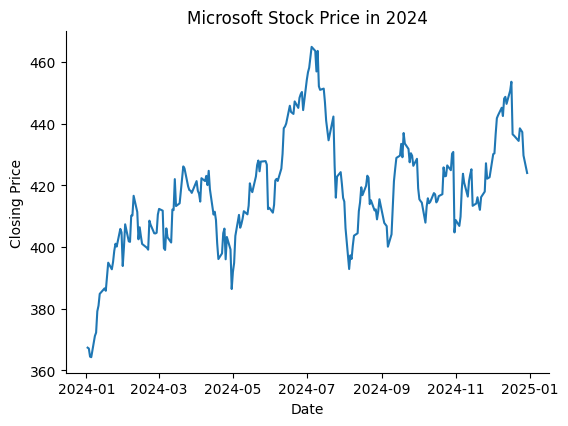

In [10]:
# visualize Mircrosft stock price movement
plot = sns.relplot(data=msft_price, x="Date", y="Close", kind="line")
plot.set(ylabel="Closing Price", title="Microsoft Stock Price in 2024");
plot.fig.set_size_inches(6, 4)

The line graph above illustrates the movement of Microsoft's stock price over the 251 trading days in 2024. Notice the significant fluctuations in stock price. By viewing these fluctuations as **random noise**, we can model stock price movement mathematically using a stochastic (random) process, known as **Geometric Brownian Motion**.

Formally, a stochastic process is said to follow a Geometric Brownian Motion (GBM), if it satisfies the following stochastic differential equation:
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$
The variables above are as follows:
- $S_t$: Stock price at time $t$
- $\mu$: Percentage drift/ Expected rate of return on stock
- $\sigma$: Historical volatility
- $dW_t$: Brownian motion

Next, we define $Z_t$ as $Z_t = ln(S_t)$.
As a result, the above general form can be rewritten as follows:
$$
dZ_t = \left(\mu -\frac{1}{2}\sigma^2 \right) dt + \sigma dW_t
$$

This implies that $dZ_t$ follows the follwing normal distribution:
$$
Z_{t+\Delta t} - Z_t \sim N\left(\mu - \frac{1}{2}\sigma^2 \Delta t, \sigma^2 \Delta t \right)
$$

Using the above general form, we can model stock price movement by choosing $\Delta t$ as $1/251$, since there were 251 trading days in 2024:
$$
Z_{\frac{i+1}{251}} - Z_{\frac{i}{251}} \sim N \left(\mu_{\text{daily}}, \sigma_{\text{daily}}^2\right) \tag{1}
$$
$$
Z_{\frac{i+1}{251}} - Z_{\frac{i}{251}} \sim N \left(\mu_{\text{annual}} - \frac{1}{2}\left(\frac{\sigma_{\text{annual}}^2}{251}\right), \ \frac{\sigma_{\text{annual}}^2}{251} \right) \tag{2}
$$

### RQ2: How can the historical volatility of stocks be estimated?

Using the derived model, we can now estimate the historical volatility of stocks $\sigma$, by first calculating the daily log returns of stock as follows:

In [13]:
# log returns: Z_t = ln(S_t)
msft_price['log_returns'] = np.log(msft_price['Close']) - np.log(msft_price['Close'].shift(1))
msft_price.head()

,Date,Close,log_returns
0,2024-01-02,367.380615,NaN
1,2024-01-03,367.113159,-0.000728
2,2024-01-04,364.478180,-0.007203
3,2024-01-05,364.289978,-0.000516
4,2024-01-08,371.164673,0.018696


Next,to **estimate annual drift and volatility**, we utilize the following equations, obtained by setting the paramters within the distribution in (1) and (2) equal to each other:
\begin{align*}
\mu_{\text{annual}} &= \mu_{\text{daily}} + \frac{1}{2}\left(\frac{\sigma_{\text{daily}}^2}{251} \right) \\
\sigma_{\text{annual}} &= \sigma_{\text{daily}}\sqrt{251}
\end{align*}

In [17]:
drift_daily = msft_price["log_returns"].mean()
vol_daily = msft_price["log_returns"].std()

annual_drift = drift_daily + (0.5 * vol_daily**2) / 251
annual_vol = vol_daily * np.sqrt(251)

print("Estimated Annualized Values for 2024:")
print(f"Percentage Drift: {round(annual_drift, 6)}")
print(f"Historic Volatility: {round(annual_vol, 6)}")

Estimated Annualized Values for 2024:
Percentage Drift: 0.000573
Historic Volatility: 0.200385


### RQ3: How can European call options be priced using **historical volatility**, and how does the estimated price compare to the market price?

To price European call options, call option data was imported for stocks of the top five S&P 500 companies from Yahoo Finance, which includes: Apple, Nvidia, Microsoft, Amazon, and Meta. The resulting dataset, after cleaning and transformation, is named `calls_df`.

In [23]:
stocks = ["AAPL", "NVDA", "MSFT", "AMZN", "META"]

# # creates a Ticker object for the top 5 S&P 500 Companies
# aapl = yf.Ticker("AAPL") # Apple
# nvda = yf.Ticker("NVDA") # NVIDIA
# msft = yf.Ticker("MSFT") # Microsoft
# amzn = yf.Ticker("AMZN") # Amazon
# meta = yf.Ticker("META") # Meta

# # gets expiration_dates for options
# exp_dates = aapl.options

# date_six_month_ltr = datetime.today().replace(month=(datetime.today().month + 6) % 12)
# exp_date = next(date for date in exp_dates if date >= date_six_month_ltr.strftime("%Y-%m-%d"))
# print(f"Expiration Date: {exp_date}")

In [24]:
# calls_df = options.get_calls("AAPL", exp_date)
# for stock in stocks[1:]:
#     df = options.get_calls(stock, exp_date)
#     calls_df = pd.concat([calls_df, df])

In [25]:
# calls_df["Trade Date"] = pd.to_datetime(calls_df["Last Trade Date (EST)"], format="%m/%d/%Y %I:%M %p").dt.date
# calls_df["Months to Exp"] = ((pd.to_datetime(exp_date) - pd.to_datetime(calls_df["Trade Date"])).dt.days / 30).astype(int)
# calls_df["Implied Volatility"] = calls_df["Implied Volatility"].str[:-1].astype(float)/100
# calls_df = calls_df[calls_df["Implied Volatility"] != 0]
# calls_df = calls_df.reset_index().drop(columns=["index", "Last Trade Date (EST)", "Change", "% Change", "Volume", "Open Interest"])
# calls_df.to_csv("call_options.csv", index=False)

In [22]:
calls_df = pd.read_csv("call_options_analysis.csv")
# 10 randonly sampled rows from calls_df
calls_df.sample(n=10)

FileNotFoundError: [Errno 2] No such file or directory: 'call_options_analysis.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')